In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.interpolate import griddata
import geopandas as gpd
import folium
import re
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

In [2]:
# Load dataset
data = pd.read_excel(r'data\SouthcentralAlaska_HydroShare.xlsx', sheet_name='Raw Data')

In [3]:
# Select relevant columns
columns = ['Latitude', 'Longitude', 'pH', 'Cond.', 'DO', 'd18O', 'dD', 'HCO3', 'NO3', 'SO4']
data = data[columns]

In [4]:
# Function to clean non-numeric values
def clean_non_numeric(val):
    if isinstance(val, str) and '<' in val:
        return float(re.sub(r'[^\d.]', '', val))
    try:
        return float(val)
    except ValueError:
        return np.nan

In [5]:
# Apply cleaning function to all columns
data = data.applymap(clean_non_numeric)

In [6]:
# Drop rows with missing values after cleaning
data = data.dropna()

In [7]:
# Normalize hydrochemical parameters (excluding Latitude and Longitude)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.iloc[:, 2:])

In [8]:
print("Preprocessed data:")
print(data.head())

Preprocessed data:
    Latitude   Longitude    pH  Cond.     DO       d18O          dD  \
1  61.462172 -148.782778  7.58  142.9  150.3 -21.297403 -155.907322   
2  61.462172 -148.782778  7.54  180.1   73.4 -17.908362 -145.877092   
4  61.476231 -148.875642  7.46  245.6  120.2 -20.269442 -148.319460   
5  61.476231 -148.875642  7.57  179.0  133.9 -21.142829 -155.128445   
6  61.476231 -148.875642  7.86  132.5  120.4 -20.210000 -151.700000   

        HCO3     NO3      SO4  
1   73.15656  0.4948  42.1372  
2  134.12036  0.0100  27.7039  
4  140.21674  1.2480  60.8400  
5   97.54208  0.5117  49.0563  
6   73.15656  0.0100  40.0913  


In [9]:
# Perform K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
data['KMeans_Cluster'] = kmeans.fit_predict(data_scaled)

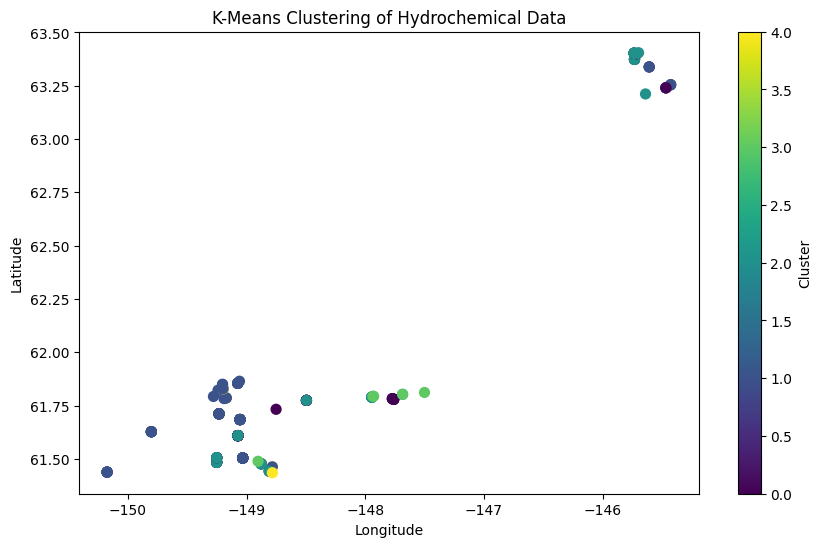

In [10]:
# Visualize clusters on a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['Longitude'], data['Latitude'], c=data['KMeans_Cluster'], cmap='viridis', s=50)
plt.colorbar(label='Cluster')
plt.title('K-Means Clustering of Hydrochemical Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [11]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
data['DBSCAN_Cluster'] = dbscan.fit_predict(data_scaled)

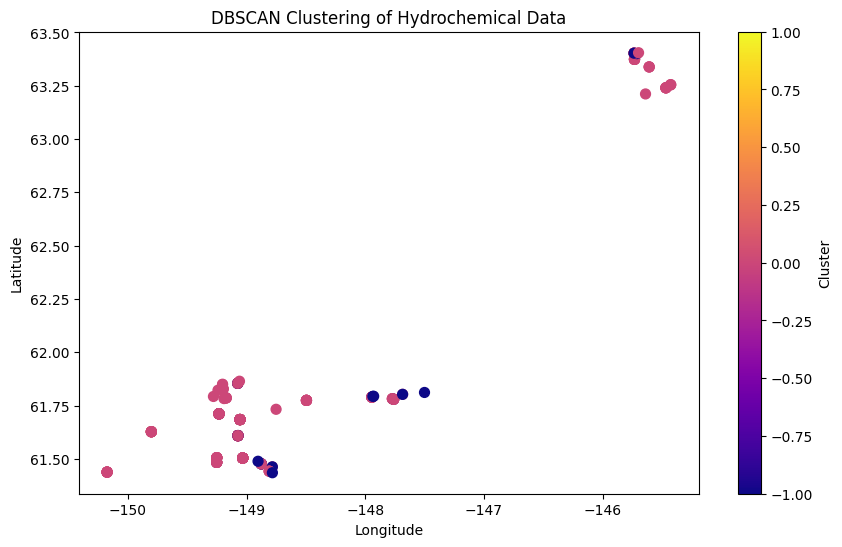

In [12]:
# Visualize DBSCAN results
plt.figure(figsize=(10, 6))
plt.scatter(data['Longitude'], data['Latitude'], c=data['DBSCAN_Cluster'], cmap='plasma', s=50)
plt.colorbar(label='Cluster')
plt.title('DBSCAN Clustering of Hydrochemical Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [13]:
# Initialize map centered on Alaska
m = folium.Map(location=[61.5, -149], zoom_start=6)

In [14]:
# Add cluster points to the map
for _, row in data.iterrows():
    cluster_color = 'blue' if row['KMeans_Cluster'] == 0 else 'red' if row['KMeans_Cluster'] == 1 else 'green'
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=5,
        color=cluster_color,
        fill=True,
        fill_opacity=0.7,
    ).add_to(m)

In [15]:
# Save the map to an HTML file
m.save("hydrochemistry_clusters_map.html")

In [16]:
# Create a grid for interpolation
grid_x, grid_y = np.mgrid[data['Longitude'].min():data['Longitude'].max():100j,
                          data['Latitude'].min():data['Latitude'].max():100j]

In [17]:
# Interpolate pH values using griddata (can use Kriging in GIS tools)
grid_pH = griddata((data['Longitude'], data['Latitude']), data['pH'], (grid_x, grid_y), method='cubic')

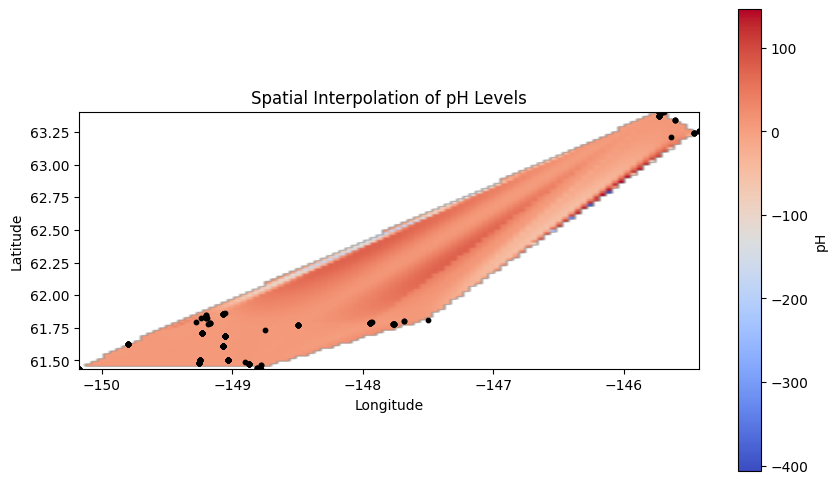

In [18]:
# Plot interpolated pH values
plt.figure(figsize=(10, 6))
plt.imshow(grid_pH.T, extent=(data['Longitude'].min(), data['Longitude'].max(),
                              data['Latitude'].min(), data['Latitude'].max()), origin='lower', cmap='coolwarm')
plt.colorbar(label='pH')
plt.scatter(data['Longitude'], data['Latitude'], c='black', s=10)
plt.title('Spatial Interpolation of pH Levels')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()